### TODO

Før aflevering

søg efter TODO

check formalia

fjern fra imports al kode kopieret ind i denne notebook

# SWMAL-01 O4

#### Group number: SWMAL_Grp 01

#### Group members:

| Name             | Student Number |
| ---------------- | -------------- |
| Kristian Lund | 20002248      |
| Jeppe Pape | 202008596      |
| Niels Kristensen | 201205937      |


## Global imports

In [ ]:
import concurrent.futures
import datetime
import json
import multiprocessing
import os  # For file path
import random
import re
from collections import Counter, defaultdict
from curses.ascii import isdigit
from dataclasses import dataclass, field
from enum import Enum  # For Enum class
from glob import glob
from os import listdir  # For file path
from typing import Dict, List

import cv2
import keras
import matplotlib.image as mpimg  # For plotting
import matplotlib.pyplot as plt  # For plotting
import numpy
import numpy as np
from keras import layers
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.regularizers import l2
from keras.utils import to_categorical  # For enum labels
from PIL import Image  # For Saving images as files
from sklearn import metrics  # For Confusion Matrix
from sklearn.model_selection import \
    train_test_split  # For train and test split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

import char_enum_pieces
import zoom_to_position as zoom
from FEN_to_64grid import (  # Our methods for converting between FEN to a 64-len string
    FEN_to_seq, seq_to_FEN)

## This document takes you through the code, for a fully run jupyter notebook, see the folder (FullDatasetRun),which has the results you see in this notebook.

## Introduction

Our O4 project will be about training a machine learning algorithm to recognize chess positions from small, computer-generated images. The system will take an image file of type .jpeg with 400 x 400 pixels and output the predicted chess position in Forsyth–Edwards Notation (FEN) https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation, the most commonly used human-readable notation for a given chess position. We will not consider the rules of chess and whether a given position is legal; only whether the position in the image is properly described.

The FEN notation works like this:

<div style="text-align: center;">
  <img src="images/chessboard_example.png" alt="Image description" style="width:50%;">
  <p><i>Chessboard example with FEN: 1b1B1K2-R2B4-7P-3b4-3R2B1-8-3R4-4Qk2. Small letter equals black pieces and capital letters equals white pieces. Empty spaces are noted with a number, showing the number of blanck spaces that appear in succession. The string is created in reading order, from upper left corner until lower right corner, where rows are seperated by a `-`.</i>
</div>

We have chosen to tackle the problem by simplifying it for the actual machine learning algorithm: Instead of taking the entire 400x400 pixel image, we divide it into 64 50x50 images. We train our model on such images to recognizing the piece (or lack thereof) there, and for our final test we deconstruct and reassemble the chess board to be recognized.

The CNN, therefore, takes a 50x50 jpeg file in the input layer and passes it through a sequence of hidden layers for feature learning (convolutional layers and pooling layers) and classification (flatten and dense layers).

<div style="text-align: center;">
  <img src="images/CNN_structure.jpg" alt="Image description" style="width:80%;">
  <h5>Typical structure of a CNN for image classification, consisting of hidden layers for feature learning and classification.</h5>
  From https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53.
</div>

In summary, the project will proceed as follows:
* Preprocess the dataset by saving images of single fields.
* Train our model on such single field images.
* Optimize and tweak our model, using the accuracy of single fields as a guide.
* Test the model on a whole chess position, by disassembling, predicting ech field, and reassembling the full position to be evaluated.


### Dataset analysis

Our dataset was found on Kaggle, here: https://www.kaggle.com/datasets/koryakinp/chess-positions?resource=download

It consists of 100000 images of chess positions, in various color combinations and using a handful of different chess sets (the graphics for the pieces). This provides some variety, and hope that the trained algorithm will not become overfitted to a specific set of chess piece graphics - although overfitting is of course still a possibility.

Our dataset is made up of 100000 jpeg files, each containing a 400x400-pixel image of a chess position, and named for the corresponding FEN string, for instance: 1B1B2K1-1B6-5N2-6k1-8-8-8-4nq2.jpeg

As we plan to divide each file into 64 50 x 50 pixel images that are the actual samples fed to our model, each sample will have 50x50x3 features. Thus, we would be able to have 6,400,000 such samples, although many would be exact duplicates. Our function to extract our field image samples from a full position, therefore, will not save duplicates, but at most a single image of a particular color combination, chess set and chess piece.

The algorithm trained on the dataset will hopefully be able to correctly analyse similar images, and give at least some information about the chess position in it. Our tests will initially be run on a set-aside sample of images from the original dataset, but it would be interesting to test it on other computer generated chess position images; we may find that there are enough similarities between how a given piece is represented in various chess sets, that the algorithm is able to correctly identify positions in a previously unseen chess set.

Below we have some code that was made to check a variaty of different relevant dataset information for pictures as described in O2.

Processing Images: 100%|██████████| 100000/100000 [00:53<00:00, 1863.85it/s]


Total images: 100000
Total dataset size: 2275.06 MB

Image Format and File Type Counts (e.g., RGB, JPEG):
100000 images, RGB, .jpeg

Number of unique dominant colors found: 141

Top 5 Dominant Color Counts (with tolerance):
Color (164, 147, 131): 3629 images
Color (179, 177, 172): 3456 images
Color (150, 102, 68): 3425 images
Color (192, 192, 192): 3421 images
Color (124, 121, 118): 3414 images

Image Dimension Counts (Width x Height):
100000 images with dimensions 400 x 400

Aspect Ratio Counts:
100000 images with aspect ratio 1.0


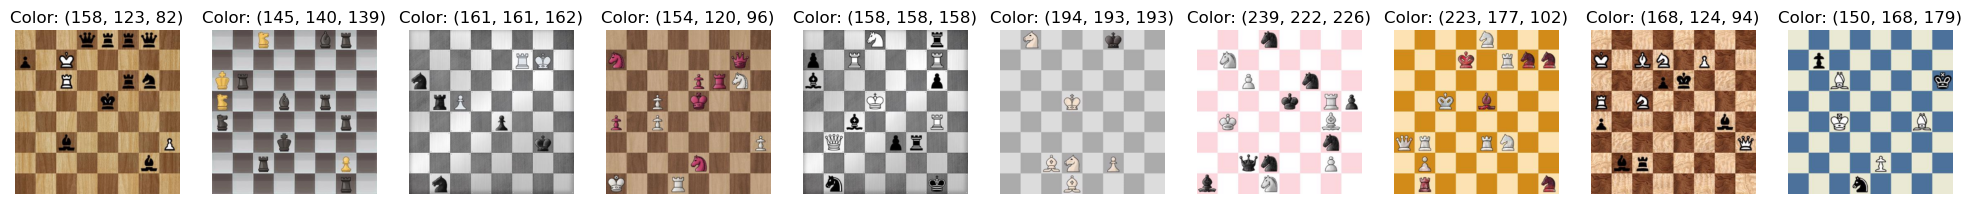

In [ ]:

# Function to apply variance and group colors within a given tolerance
def is_within_tolerance(color1, color2, tolerance=4):
    """Check if two colors are within the given RGB tolerance."""
    return all(abs(c1 - c2) <= tolerance for c1, c2 in zip(color1, color2))

# Function to quantize colors (reduce sensitivity to small variations)
def quantize_color(color, factor=30):
    return tuple((color // factor) * factor)

# Function to calculate the dominant color by finding the most frequent pixel value
def get_dominant_color(image):
    pixels = image.reshape(-1, 3)
    dominant_color = np.mean(pixels, axis=0)  # Averaging pixels for faster result
    return tuple(dominant_color.astype(int))  # Convert NumPy array to tuple (fixes error)

# Function to load and resize images for consistent processing
def load_image(image_path, size=(50, 50)):  # Smaller size for faster processing
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.resize(image, size)

# Function to detect image type: grayscale, RGB, etc.
def detect_image_type(image_path):
    img = cv2.imread(image_path)
    if len(img.shape) == 2:
        return 'Grayscale'
    elif len(img.shape) == 3 and img.shape[2] == 3:
        return 'RGB'
    elif len(img.shape) == 3 and img.shape[2] == 4:
        return 'Multispectral'
    return 'Unknown'

# Function to detect image dimensions, aspect ratio, and size in bytes
def get_image_properties(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        height, width, channels = img.shape
        image_size = os.path.getsize(image_path)  # Size in bytes
        aspect_ratio = round(width / height, 2)  # Rounded aspect ratio to 2 decimal places
        return (width, height, aspect_ratio, image_size)
    return (0, 0, 0, 0)

# Function to process each image to extract properties, including dominant color
def process_image(image_path):
    filename = os.path.basename(image_path)
    
    # Load and resize the image
    image = load_image(image_path)
    
    # Calculate the dominant color (faster using averaging)
    dominant_color = get_dominant_color(image)
    
    # Detect image properties: dimensions, aspect ratio, and size
    width, height, aspect_ratio, image_size = get_image_properties(image_path)
    
    # Detect image type
    img_type = detect_image_type(image_path)
    
    # Get file type
    file_type = os.path.splitext(filename)[-1].lower()
    
    return {
        'filename': filename,
        'img_type': img_type,
        'file_type': file_type,
        'dominant_color': dominant_color,  # Now stored as a tuple
        'width': width,
        'height': height,
        'aspect_ratio': aspect_ratio,
        'image_size': image_size,
        'image_path': image_path  # Include the path for later use in display
    }

# Function to group colors with variance tolerance
def group_colors_with_tolerance(dominant_color_counts, tolerance=4):
    grouped_colors = {}
    
    for color, count in dominant_color_counts.items():
        matched = False
        # Try to find a group that matches the color within tolerance
        for grouped_color in grouped_colors:
            if is_within_tolerance(color, grouped_color, tolerance):
                grouped_colors[grouped_color] += count
                matched = True
                break
        
        # If no group was found, add this color as a new group
        if not matched:
            grouped_colors[color] = count
    
    return grouped_colors

# Function to process images in parallel using a thread pool with progress bar
def process_images_in_parallel(image_files, max_workers=None):
    results = []
    
    # Wrap the image_files iterable with tqdm to display progress bar
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_image = {executor.submit(process_image, image_path): image_path for image_path in image_files}
        
        # tqdm progress bar for each completed image
        for future in tqdm(concurrent.futures.as_completed(future_to_image), total=len(image_files), desc="Processing Images"):
            results.append(future.result())
    
    return results

# Function to display images from 10 different color groups
def display_sample_images_by_color(results, n_samples=10):
    # Group images by their dominant color
    color_groups = defaultdict(list)
    for item in results:
        color_groups[item['dominant_color']].append(item['image_path'])
    
    # Select 10 random dominant colors
    selected_colors = random.sample(list(color_groups.keys()), min(n_samples, len(color_groups)))
    
    # Display one image from each selected color group
    fig, axes = plt.subplots(1, n_samples, figsize=(25, 15))  # Larger image size
    for i, color in enumerate(selected_colors):
        img_path = random.choice(color_groups[color])  # Choose one random image from the group
        img = load_image(img_path, size=(300, 300))  # Larger image size for display
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Color: {color}")
    
    plt.show()

# Function to summarize the results
def summarize_results(results):
    total_images = len(results)
    total_size = sum(item['image_size'] for item in results)
    
    # Count image formats and file types
    format_file_counts = Counter((item['img_type'], item['file_type']) for item in results)
    
    # Count dominant colors
    dominant_color_counts = Counter(item['dominant_color'] for item in results)
    
    # Group dominant colors with tolerance
    grouped_colors = group_colors_with_tolerance(dominant_color_counts, tolerance=4)
    
    # Count image dimensions (width x height)
    dimension_counts = Counter((item['width'], item['height']) for item in results)
    
    # Count aspect ratios
    aspect_ratio_counts = Counter(item['aspect_ratio'] for item in results)

    # Print the summary
    print(f"Total images: {total_images}")
    print(f"Total dataset size: {total_size / (1024 * 1024):.2f} MB")
    
    print("\nImage Format and File Type Counts (e.g., RGB, JPEG):")
    for (img_type, file_type), count in format_file_counts.items():
        print(f"{count} images, {img_type}, {file_type}")
    
    print(f"\nNumber of unique dominant colors found: {len(grouped_colors)}")
    
    print("\nTop 5 Dominant Color Counts (with tolerance):")
    for color, count in Counter(grouped_colors).most_common(5):  # Show only top 5 dominant colors
        print(f"Color {color}: {count} images")
    
    print("\nImage Dimension Counts (Width x Height):")
    for (width, height), count in dimension_counts.items():
        print(f"{count} images with dimensions {width} x {height}")
    
    print("\nAspect Ratio Counts:")
    for aspect_ratio, count in aspect_ratio_counts.items():
        print(f"{count} images with aspect ratio {aspect_ratio}")
    
    # Display 10 images from 10 different color dominant groups
    display_sample_images_by_color(results)

# Main function to run the optimized process
def main():
    # Get the number of CPU cores (16 threads in your case)
    num_workers = multiprocessing.cpu_count()
    
    # Load the .jpeg images
    image_folder = './dataset/combined/'  # Set this to your dataset path
    image_files = glob(os.path.join(image_folder, '*.jpeg'))
    
    # Process the images in parallel using limited threads
    results = process_images_in_parallel(image_files, max_workers=int(num_workers * 0.75))  # Use 75% CPU
    
    # Summarize the results and display sample images
    summarize_results(results)

if __name__ == "__main__":
    main()


So as we can see there is a total of 100.000 picture in the dataset, all jpegs, all rgb and all 400 x 400 dimension. Alongside this we calculated an estimated dominant color count, with a tolerance of +/- 5 (since the different amount of pieces and their colors can have an overall big impact on this meassurement, leading identical boards + pieces to be recognized as different "types", unless we give it a slight tolerance). Even with such a tolerance the exact number of different combinations of board colors and piece colors in the set isn´t 100% accurate however it is a good estimate of the amount.

## ML data processering

Early on it was decided to split the chessboard images into 64 images of the individual chessboard fields and use these to train the CNN. This was expected to greatly simplify the classification task. After training, the CNN model was used to predict the chess pieces of the individual chessboard fields, which could then be pieced together to give the predicted FEN string.

<div style="text-align: center;">
  <img src="images/chessboard_split.jpeg" alt="Image description" style="width:80%;">
  <h5></h5>
</div>

## Handling position data

FEN notation is optimized for being quick to write down, and it therefore uses numbers for blank spaces and an end-of-row delimiter for readability. This makes it difficult to work with when comparing two positions, looping over the notation, etc. We have therefore written two helper functions that convert to and from FEN notation and our "sequence" notation. The latter is simply a 64 length string, with each index of the string corresponding to a specific field on the board. We use the same characters as FEN notation for pieces, except "_" which is used for a blank field instead of numbers:

In [ ]:

def FEN_to_seq(FEN):
    sequence = ""
    assert isinstance(FEN, str)
    for i in range(len(FEN)):
        if FEN[i] == '-': continue
        if isdigit(FEN[i]) : sequence = sequence + '_' * int(FEN[i])
        else: sequence = sequence + FEN[i]
    assert len(sequence) == 64
    return sequence

def seq_to_FEN(seq):
    assert isinstance(seq, str)
    FEN = ""
    blankspaceit = 0

    def add_blankspaces_contingently():
        nonlocal FEN, blankspaceit
        if blankspaceit > 0:
            FEN = FEN + str(blankspaceit)
            blankspaceit = 0
    
    row = 0        
    while row < 8 :
        column = 0
        while column < 8 :
            currentItem = seq[(8 * row) + column]
            if currentItem == '_':
                blankspaceit += 1
            else:
                add_blankspaces_contingently()
                FEN = FEN + currentItem
            column += 1
        add_blankspaces_contingently()
        if row < 7: FEN = FEN + "-"
        row += 1
    return FEN

For example, the two FEN and sequence notation strings here describe the same chess position and can be converted to and from each other using the above functions:

FEN:

1B1K4-1p5N-7p-1qp5-n1P5-8-6k1-b7

Sequence:

_B_K_____p_____N_______p_qp_____n_P___________________k_b_______

We can therefore dispense with the FEN notation; any accuracy measured on the sequence notation is an equal description of how accurate our model is.

### Splitting chessboard images into single fields

In order to split images of chessboards into images of the individual chessboard fields a function that can zoom into a specific field is defined `zoom_to_position(image, position)`, which takes the 400x400x3 image and a position (from 1 to 64) and outputs an array containing the 50x50x3 image.

In [2]:
#Function to zoom in on a single space
def zoom_to_position(image, position):
    #Assert that image is correct size
    assert image.shape == (400, 400, 3), f"Image shape is {image.shape}, expected (400, 400, 3)"
    assert 1 <= position & position <= 64, f"Position is {position}, expected (1-64)"

    #from position to x/y
    x = (position-1)%8
    y = int((position-1)/8)

    #Make sub array
    sub_image_array = image[y*50:y*50+50, x*50:x*50+50, :]

    return sub_image_array

Below an example is shown, where `zoom_to_position(image, position)` is used to zoom into position 2 (here a black bishop) of a chessboard image.

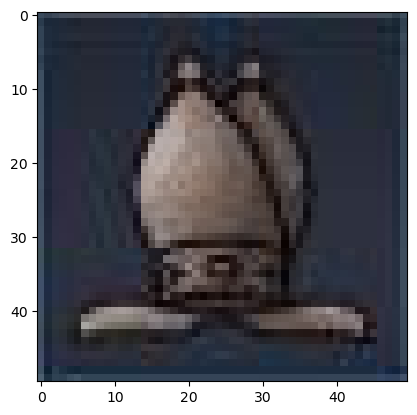

In [3]:
#Load single chessboard data
image_path = 'images\\1b1B1K2-R2B4-7P-3b4-3R2B1-8-3R4-4Qk2.jpeg'
image = mpimg.imread(image_path)
zoom_image = zoom_to_position(image,2)
plt.imshow(zoom_image)

Next a function, `Save_individual_positions(data_path, destination_path)` was defined that scans a folder (`data_path`) for chessboard images, splits all of these using the `zoom_to_position(image, position)` and saves the individual chessboard field images in a new folder (`destination_path`). Saving these once, as opposed to splitting the chessboard images everytime the pipeline is rerun, saves time and enables us to refind specific images later in the process. 

The names of the new images starts with the letter corresponding to the FEN chess piece symbol (13 kinds) + the position (1-64), followed by the configuration of the chessboard (sequence name). Thus the first element in the name of the split images corresponds to the label of it. With this naming we can also refind the original chessboard image of these. The process also insures that duplicates are removed, as duplicate image files are overwritten per default. As most of the dataset consist of empty fields this is expected to remove a bias towards these in the categorization.

In [4]:
#Load data into individual position images
# This method also removes duplicates
def Save_individual_positions(data_path, destination_path):
        for file in os.listdir(data_path):
                #Get FEN from file
                FEN_string = file.replace('.jpeg', '')
                #Convert to seq name
                chessboard_seq = FEN_to_seq(FEN_string)
                #Go through all jpeg images
                if (file.endswith(".jpeg")):
                        # Store file as image data
                        file_path = os.path.join(data_path, file)
                        image = mpimg.imread(file_path)
                        #For all positions
                        for i in range(1,65):
                                #Make file name
                                if (chessboard_seq[i-1] != "_"):
                                        new_file_name = os.path.join(chessboard_seq[i-1]+str(i)+"/", chessboard_seq,'.jpeg')
                                else:
                                        new_file_name = os.path.join(chessboard_seq[i-1]+"_", chessboard_seq,'.jpeg')
                                new_file_name = new_file_name.replace('\\','')
                                #Save image
                                zoom_image = zoom_to_position(image,i)
                                new_image = Image.fromarray(zoom_image.astype('uint8'))
                                new_image.save(os.path.join(destination_path, new_file_name))

### Loading the data

To load data from a folder a function `Import_individual_positions(data_path)` was made. Here each 50x50 image is loaded into the X matrix and the label corresponds to the first element in the name of each file.

In [5]:
#Load data into individual position images
def Import_individual_positions(data_path):
        X = []
        y = []
        for file in os.listdir(data_path):
                #Go through all jpeg images
                if (file.endswith(".jpeg")):
                        # Store file as image data
                        file_path = os.path.join(data_path, file)
                        image = mpimg.imread(file_path)
                        #store image in X
                        X.append(image)
                        #store label
                        y.append(file[0])
        return X, y

From this the X_raw (data matrix) and y_raw (vector containing data labels) can be defined.

In [6]:
data_path = r'position_image_examples' #Set data folder
X_raw, y_raw = Import_individual_positions(data_path)

Next the X_raw and y_raw are converted into numpy arrays for when training the CNN. The y_raw is also converted from categorical char labels into categorical int values, using the `class CharEnum(Enum)` for the CNN model to work on. Next X is reshapen to ensure that it has correct dimensions for the CNN.

In [7]:
class CharEnum(Enum):
    _ = 0
    P = 1
    N = 2
    B = 3
    R = 4
    Q = 5
    K = 6
    p = 7
    n = 8
    b = 9
    r = 10
    q = 11
    k = 12

In [8]:
#Convert to numpy array
X = np.array(X_raw)
y_num = [CharEnum[char].value for char in y_raw] #Convert ASCII to numbers from 1-13
y = np.array(y_num)

#Preprocess
X = X.reshape(-1, 50, 50, 3).astype('float32') / 255 #RGB pixels from 0-255
y = to_categorical(y, num_classes=None) #Convert int to binary class matrix (One-hot)

This gives a datamatrix, X, of dimensions (numOfSamples, 50, 50, 3) and a y array of dimensions (numOfSamples, 13) where each y element contains a binary class matrix of the 13 labels, 0-13 for one-hot conding.

### Train and test split

Data is already split into a train and test sets. See further down in our model, where we implement a .2 validation split for training, in our training data.

## Choice of algorithm

In [ ]:

#Advanced
def make_advanced_model():
    advanced_model = keras.Sequential()
    advanced_model.add(layers.Conv2D(filters = 6, kernel_size=(2, 2), activation='relu', input_shape=(50,50,3))) #Input layer
    advanced_model.add(layers.MaxPooling2D(pool_size=(2, 2))) #Downsampling layer
    advanced_model.add(layers.Conv2D(filters = 16, kernel_size=(2, 2), activation='relu'))
    advanced_model.add(layers.AveragePooling2D(pool_size=(2, 2)))

    advanced_model.add(layers.Flatten()) #Flatten layer

    # Assuming advanced_model is defined as Sequential or Functional API
    advanced_model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Add L2 regularization
    advanced_model.add(Dropout(0.5))  # Add Dropout layer
    advanced_model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    advanced_model.add(Dropout(0.5))
    advanced_model.add(layers.Dense((13), activation='softmax'))  # Output layer

    return advanced_model

advanced_model = make_advanced_model()
advanced_model.summary()

### Advanced_model(): 
The particular model choosen for the ML is keras.Sequential. It is simply a sequential way of grouping the subsequent layers into a model.

Now lets talk a little about the layers choosen and what they do.

![This is a sample image](images/modeloutput.png)


Conv2D: It takes a picture and maps it out into a size and shape defined by kernel and the input shape, in our example we take an input shape of 50x50 pixels and 3 for RGB. We choose a filter of 6 and we get back 168 params, this is essentially our 3x3 matrix, times our 3 rgb values and then times our filters. 9x3x6=162 and then we add an additional 6 for our bias layer giving us a total of 168 params. The shape of the picture that the convd gets in the process gets reduced to 48x48 since the kernelsize of 3x3 reduces it by 2.

MaxPooling2D: This is a pooling layer, it downsamples the image over an input window (in our case 2x2) and chooses its max value. In essence it turns our 48x48 pictures to 24x24. 

Conv2D 2: Same as the previous one, however here we add several extra filters and the resulting output is then 880 params. Reason for calling conv2d to maxpooling2d and hen conv2d is to better extrapolate first more simple features like lines and such and then as the picture is downsampled we better extrapolate more complex features like entire shapes.

AveragePooling2D: Does the exact same as the maxpooling except here it chooses the average value of the input window. In our case it further reduces the image to 12x12

Flatten: The flatten layer takes the size of the image we then have of 12x12 and flattens it to a 1d vector. Converting our 12x12 matrix into 144 individual numbers. Like so [124123..., 123145....., ...]

Dense: Is our "decision" layer essentially, it takes the flattened 1d vectors and first categorizes them into 120 units, then 84 and lastly 13, which is the amount of different chess pieces in 2 colours and 1 blank space, that we can have on our chess board. The ReLU activation function is used in the first two Dense layers because it introduces non-linearity, enabling the model to learn complex relationships between the extracted features. In Dense layer 1, ReLU helps the network start to identify meaningful patterns from the flattened input (e.g., edges, shapes, or textures). In Dense layer 2, ReLU further refines these patterns into a more abstract representation, ensuring that the model can handle intricate variations in the data. Softmax is used in the last Dense layer because it converts raw outputs ("logits") into probabilities between 0 and 1. These probabilities represent the likelihood of each class (e.g., chess pieces or blank space). Essentially, it takes the 84 units from the previous layer and outputs 13 probabilities, focusing on which class the input is "most likely" to belong to.



## Performance metrics

### Model evaluation

In [ ]:
#### Test/Train split 
X_train = X
y_train = y


# Shuffle X_train and y_train
X_train, y_train = shuffle(X_train, y_train, random_state=42)  # Random state for reproducibility


datagen = ImageDataGenerator(validation_split=0.2)
train_generator = datagen.flow(X_train, y_train, batch_size=32, subset='training')
validation_generator = datagen.flow(X_train, y_train, batch_size=32, subset='validation')
#Compile
advanced_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Train


early_stopping = EarlyStopping(
    monitor='val_loss',             # Monitor validation loss
    patience=5,                     # Stop if no improvement after 5 epochs
    restore_best_weights=True       # Restore the best weights at the end
)

history = advanced_model.fit(
    train_generator,
    epochs=50,                      # Increase epochs if using EarlyStopping
    validation_data=validation_generator,
    callbacks=[early_stopping]      # Add callback
)

#Save
advanced_model.save('advnced_model.keras')

First we have the code for our model, we import our data, shuffle it, since some of our previous functions now make our folder have organized pictures by type, via the naming convention. This originally led to some issues, that we didnt realise until we analyzed it and knew shuffling was needed.

We then set up our imagegenerators with one being a validation generator at 20% the size of the training set.


We simply take it with our earlystopping data fit the model and save it. The results can be seen below with great overall accuracy scores and validation accuracy.

![This is a sample image](images/accuracyscore.png)

#### Calculate accuracy and loss from whole test set


In [ ]:
loss_from_test, acc_from_test = advanced_model.evaluate(X_test, y_test)
print(f"Loss: {loss_from_test}")
print(f"Accuracy: {acc_from_test}")

And as we can see, if we look at the evaluation of our model on the test set, it also gives an amazing score, which we will go into deeper detail later with a confusion matrix as well. But the short point is, that the model is extremely accurate at predicting the exact position and type of piece on the whole image with our methodology.
![This is a sample image](images/accuracyscoretest.png)

### Learning curve

In [ ]:
history_dict = history.history # Training history

fig, axs = plt.subplots(2)
axs[0].plot(history_dict['accuracy'], label='Training Accuracy')
axs[0].plot(history_dict['val_accuracy'], label='Validation Accuracy')
axs[0].legend()
axs[0].set_title('Learning Curves')
axs[0].set_ylabel('Accuracy')
axs[1].plot(history_dict['loss'], label='Training Loss')
axs[1].plot(history_dict['val_loss'], label='Validation Loss')
axs[1].legend()
axs[1].set_ylabel('Cross-Entropy Loss')
plt.xlabel('Epochs')

As seen in the code above this part, we have implemented some early stopping to prevent overfitting, wich we initially thought we needed as with the issue of our model originally only training on the ordered test images, it meant it kept testing on 80% pictures in the order and validating on 20% in the order, which before shuffling lead to insanely good accuracy scores and terrible validation scores near 20%. Seeing as we have later recognized this was due to the lack of shuffling we dont really see the impact, but decided to keep it in anyway and the results are now great. You could argue, that we could have stopped training even earlier, with some rougher early stopping criteria, but it was mostly the preprocessing of the data that took a while, so it wasn´t really a problem and the results are very good.

![This is a sample image](images/learningcurve.png)

And from the learning curve, we can see that we do not have any issues with overfitting, we keep learning over the epochs and we get an "increasingly" better validation, even though it is realitively small. Could there be potential underfitting in terms of our dataset lacking variability ? We cant know for sure, but our dataset is extremely varied in colours and even some differing chess set piece variations. But you could argue that even though we have 100.000 pictures, such a dataset is just going to be very none-variable otherwise, as there isnt much you can do to vary a chessboard, chesspieces and more, while keeping it within this realm, as thats just how "online chess" really works.

### Confusion matrix

In order to study the models ability to predict the 13 kinds of chess pieces a confusion matrix is made. Here the models predicted label (type of chess piece) from approximately 230.000 images of chess pieces were compared against the true labels. Results (figure below) shows very good predictions for all 13 labels. For many chess pieces (P, N, K, n, r, q) no mistakes are made. The maximum number of errors appear for p, which is wrongly predicted to be a P in 12 out of 17936 cases.

In [ ]:
prediction = model.predict(X_test) #Predict labels from test set, X_test
y_pred = np.argmax(prediction, axis=1) #Find label with highest prediction value (softmax)
y_true = np.argmax(y_test_conv, axis=1) #Get the true label

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
class_names = [char.name for char in CharEnum] #Convert categorical number to char labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)
cm_display.plot()
plt.show()

<div style="text-align: center;">
  <img src="images/confusion.png" alt="Image description" style="width:30%;">
  <h5>Confusion matrix</h5>
</div>

## Optimizations and improvements

After the initial implementation, we experimented with different training settings. Mainly we evaluated using confusion matrices, testing on individul field images only.

TODO: Add some examples of changes?

Later, we wrote a prediction function for a whole chessboard position image, and for a whole directory of such images:

In [3]:
@dataclass
class FilePredictionResult:
    errors_num: int = 0
    err_positions: List[int] = field(default_factory=list)      # Note: 0-indexed, runs from 0-63 (to be used as indexes into string)
    err_pieces: List[str] = field(default_factory=list)

@dataclass
class FolderPredictionResult:

    # Metadata
    timestamp: datetime.datetime
    model: str
    folder: str
    # By file
    total_files: int = 0
    total_files_w_errors: int = 0
    error_ratio_by_files: float = .0
    file_ratio_of_total_by_error_ratio: Dict[float, float] = field(
        default_factory=lambda: {key: 0 for key in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
    )
    # By fields
    total_fields: int = 0
    total_fields_w_errors: int = 0
    error_ratio_by_fields: float = .0
    # By piece
    list_of_pieces_in_truth: defaultdict[str, int] = field(default_factory=lambda: defaultdict(int))
    list_of_errors_by_piece: defaultdict[str, int] = field(default_factory=lambda: defaultdict(int))
    error_ratio_by_pieces: defaultdict[str, float] = field(default_factory=lambda: defaultdict(int))
    # File list
    file_list_by_error_ratio: Dict[float, List[str]] = field(
        default_factory=lambda: {key: [] for key in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
    )

class predictor:
    def __init__(self, modelpath):
        self.model = keras.models.load_model(modelpath)
        self.modelpath = modelpath
    def predict_file(self, filename):
        # Init
        rv = FilePredictionResult(0, [], [])
        filename_wo_ending = filename.replace('.jpeg', '')                  # Removing last name
        FEN_string_true = re.sub(r".*[/\\]", "", filename_wo_ending)        # Removing everything before last folder delimiter
        seq_string_true = FEN_to_seq(FEN_string_true)
        field_image_array = []
        image = mpimg.imread(filename)

        # Construct matrix to predict on

        for position in range(1,65) :
            field_image = np.array(zoom.zoom_to_position(np.array(image), position))
            field_image = field_image.reshape(50, 50, 3).astype('float32') / 255
            field_image_array.append( field_image )
        field_image_array = np.array(field_image_array)

        # Make prediction
        prediction_array_raw = self.model.predict(field_image_array)

        # Construct sequence array from prediction array
        seq_string_prediction_nums = np.argmax(prediction_array_raw, axis=1)
        seq_string_prediction = ""
        for position in range(0,64):
            seq_string_prediction += char_enum_pieces.CharEnum(seq_string_prediction_nums[position]).name

        # Note errors
        for i in range(0,64):
            if (seq_string_true[i] != seq_string_prediction[i]):
                rv.errors_num += 1
                rv.err_positions.append(i)
                rv.err_pieces.append( str(seq_string_true[i]) + str(seq_string_prediction[i]) )

        return rv

    def predict_dir(self, directorypath):
        rv = FolderPredictionResult(timestamp = datetime.datetime.now(), folder=directorypath, model=self.modelpath)
        last_file_result = FilePredictionResult
        files_by_error_ratio_count = {key: 0 for key in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

        for file in os.listdir(directorypath):
            if file.endswith(".jpeg"):
                # Get file prediction
                file_w_path = os.path.join(directorypath, file)
                rv.total_files += 1
                rv.total_fields += 64
                last_file_result = self.predict_file(file_w_path)

                # Populate simple return values
                for char in FEN_to_seq(file.replace('.jpeg', '')):
                    rv.list_of_pieces_in_truth[char] += 1
                if (last_file_result.errors_num != 0):
                    rv.total_files_w_errors += 1
                    rv.total_fields_w_errors += last_file_result.errors_num
                    for error_piece in last_file_result.err_pieces:
                        rv.list_of_errors_by_piece[error_piece] += 1                        
                ratio_error = np.round(last_file_result.errors_num / 64, decimals=1)
                files_by_error_ratio_count[ratio_error] += 1
                rv.file_list_by_error_ratio[ratio_error].append(file)


        # Generate return value ratios, etc.
        for ratio, count in files_by_error_ratio_count.items():
            rv.file_ratio_of_total_by_error_ratio[ratio] = np.round(count / rv.total_files, decimals=2)
        rv.error_ratio_by_files = rv.total_files_w_errors / rv.total_files
        rv.error_ratio_by_fields = rv.total_fields_w_errors / rv.total_fields

        total_errors_for_piece = defaultdict(int)
        for key, value in rv.list_of_errors_by_piece.items():
            true_char_that_lead_to_error = key[0]
            total_errors_for_piece[true_char_that_lead_to_error] += value
        for key, value in total_errors_for_piece.items():
            rv.error_ratio_by_pieces[key] += value / rv.list_of_pieces_in_truth[key]
            

        # Save as json

        savefile_fullpath = os.path.join(directorypath, str(rv.timestamp.isoformat()) + ".json")
        savefile_fullpath = re.sub(r":", "-", savefile_fullpath)        # : to - to help Windows

        with open(savefile_fullpath, "w" ) as savefile:
            json.dump(vars(rv), savefile, default=json_serializer, indent=4)

        print(f"Saved output to: {savefile_fullpath}" )        
        return rv


def json_serializer(object):
    if isinstance(object, datetime.datetime):
        return object.isoformat()
    if isinstance(object, defaultdict):
        return dict(object)


The predict_dir() function saves the results as a .json file, to allow us to save results and quickly share both models, and the details of their results. By saving the filenames of files with an a given error ratio, we were able to quickly see what kinds of images our models worked and failed on. For instance, at one point we saw some odd clustering where about a third of the images yielded very low error rate, while about a quarter had an extremely high:

2024-12-02T11-30-37.086320.json:
	...
	"files_by_error_ratio": {
		"0.0": 0.06,
		"0.1": 0.28,
		"0.2": 0.05,
		"0.3": 0.02,
		"0.4": 0.02,
		"0.5": 0.15,
		"0.6": 0.09,
		"0.7": 0.07,
		"0.8": 0.05,
		"0.9": 0.18,
		"1.0": 0.05
	}...

Also having the filenames (under another key divided into the same error ratios), we were able to do spot-checks and see that it was certain colors combinations that were failing. This was uselful as this data was not present in the initial dataset, and was less visible when testing individual fields.

## Results

On our final test, we ran predict_dir on the 20000 files in the test set. Of these, errors were found in only 1441 for an accuracy of 0.927.

This does not directly correlate with our confusion matrices, which measure against a single field. In our test run, the relevant statistics are a totanl number of fields of 1280000, with 4839 errors, for an accuracy of 0.996.

We also see, as expected from our last confusion matrix, that the errors are almost exclusively blank spaces being mistaken for certain black pieces:

| True piece | Mistaken for | Count |
| ---------------- | -------------- | -------------- | 
| _ | p      | 3680 |
| _ | n      |  570 |
| _ | k      |  562 |
| N | R      |    5 |
| N | Q      |    3 |
| q | r      |    2 |
| B | Q      |    2 |
| q | b      |    1 |
| r | b      |    1 |
| Q | K      |    1 |
| q | n      |    1 |
| Q | B      |    1 |
| n | _      |    1 |

## Conclusions

The basic strategy of dividing the images into fields for training definitely worked. We did a quick test of the direct approach, where a model was trained on the full chess position, with the following results:

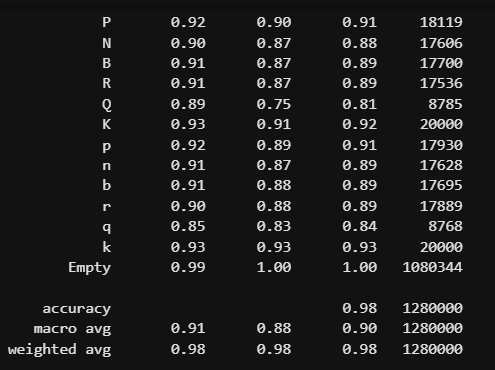

The first column is the precision, which seems dependent on how many examples of the given piece were in each image (few kings and especially queens, many pawns and blank spaces). Our final results were much more consistent and simply better.

Still, our final approach did not fully take into account the predominance of certain categories over others. While we did exclude duplicates of the same field image from a given chess position image, we did not ensure that eg. enough queens were represented as compared to pawns. Ensuring an equal amount of each output category in the training data might have improved out results. 

We could have been more efficient by being more precise about labelling our data, and having a consistent strategy for training our models. At one point, a model was trained on only blank spaces, since we were using the first couple of thousands files from our field image folder, sorted alphabetically and all files started with a char denoting their content. Had we started out by setting up a function to properly select input images, such dead ends could have been avoided.

On the whole, we are satisfied with the results, but not surprised: Our dataset of field images was vast compared to the number of categories we were looking for. Also, the computer-generated nature of the input not only enabled our division into fields, but also ensured that each category had relatively little internal variation; although the color combination and graphical details of the chess sets differed, there are many similarities between the various kinds of eg. pawns, and the dataset images are very consistent.